In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [2]:
url = "https://raw.githubusercontent.com/thieu1995/csv-files/main/data/timeseries/multivariate/exchange_rate/exchange_rate.txt"
data = pd.read_csv(url)

In [3]:
X = data.iloc[:, :-2]
y = data.iloc[:, -2:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)


In [5]:
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'SVR': SVR()
}

param_grids = {
    'LinearRegression': {
        'estimator__fit_intercept': [True, False]
    },
    'RandomForest': {
        'estimator__n_estimators': [50, 100, 200],
        'estimator__max_depth': [None, 10, 20],
        'estimator__min_samples_split': [2, 5, 10]
    },
    'SVR': {
        'estimator__C': [0.1, 1, 10],
        'estimator__epsilon': [0.1, 0.2, 0.5],
        'estimator__kernel': ['linear', 'poly', 'rbf']
    }
}


Optimizing LinearRegression...
Best parameters for LinearRegression: {'estimator__fit_intercept': False}
Optimizing RandomForest...
Best parameters for RandomForest: {'estimator__max_depth': 20, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 200}
Optimizing SVR...
Best parameters for SVR: {'estimator__C': 10, 'estimator__epsilon': 0.1, 'estimator__kernel': 'rbf'}
                      RMSE       MAE        R2      MAPE
LinearRegression  0.026597  0.021443  0.923936  0.033329
RandomForest      0.004329  0.002631  0.998252  0.004088
SVR               0.008466  0.006428  0.992841  0.009967


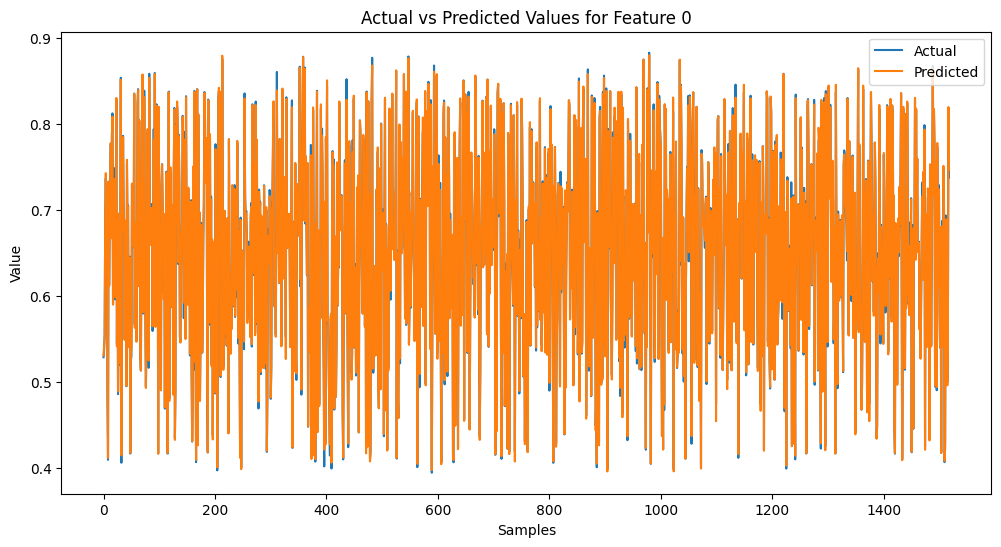

In [6]:
best_models = {}
for model_name in models:
    print(f"Optimizing {model_name}...")
    model = MultiOutputRegressor(models[model_name])
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train_scaled)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

def evaluate_model(model, X_test, y_test, scaler_y):
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test = scaler_y.inverse_transform(y_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    return rmse, mae, r2, mape

results = {}
for model_name in best_models:
    rmse, mae, r2, mape = evaluate_model(best_models[model_name], X_test_scaled, y_test_scaled, scaler_y)
    results[model_name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }

results_df = pd.DataFrame(results).T
print(results_df)


def plot_predictions(model, X_test, y_test, scaler_y, feature_index=0):
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test = scaler_y.inverse_transform(y_test)

    plt.figure(figsize=(12, 6))
    plt.plot(y_test[:, feature_index], label='Actual')
    plt.plot(y_pred[:, feature_index], label='Predicted')
    plt.xlabel('Samples')
    plt.ylabel('Value')
    plt.title(f'Actual vs Predicted Values for Feature {feature_index}')
    plt.legend()
    plt.show()

plot_predictions(best_models['RandomForest'], X_test_scaled, y_test_scaled, scaler_y, feature_index=0)